# Fabric Model Analysis & Optimization Toolkit

## Overview
This notebook provides comprehensive functions for analyzing semantic models to identify unused objects (measures, columns, and tables) that can be removed to optimize model performance and reduce complexity.

## Key Features
- **Unused Measures Detection**: Identifies measures not referenced in calculations or reports
- **Unused Columns Detection**: Finds columns not used in calculations or visualizations
- **Unused Tables Detection**: Locates tables with no references in the model
- **Relationship Analysis**: Examines table relationships for optimization opportunities

## Required Libraries
- `SemPy` which is part of the `semantic-link` feature with Core Fabric semantic model operations

---

## Installation & Dependencies

Install the required semantic-link-labs package for extended Fabric analytics capabilities.

In [1]:
# Install semantic-link-labs for extended Fabric analytics
!pip install semantic-link-labs

StatementMeta(, 58f2a5b9-4033-4bdf-bd03-8a202fd7a88c, 3, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 771.5 kB/s eta 0:00:00:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.7/764.7 kB 1.4 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 47.2 MB/s eta 0:00:00
  Attempting uninstall: azure-core
    Found existing installation: azure-core 1.30.2
    Uninstalling azure-core-1.30.2:
      Successfully uninstalled azure-core-1.30.2
  Attempting uninstall: semantic-link-sempy
    Found existing installation: semantic-link-sempy 0.11.0
    Uninstalling semantic-link-sempy-0.11.0:
      Successfully uninstalled semantic-link-sempy-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

## Library Imports & Configuration

Import essential libraries for Fabric model analysis:
- **`sempy.fabric`**: Primary interface for Fabric operations
- **`sempy_labs.report`**: Report analysis and object extraction
- **`pandas`**: Data manipulation framework
- **`matplotlib.pyplot`**: Data visualization and charting


In [2]:
# Import core libraries for Fabric model analysis
import pandas as pd
import matplotlib.pyplot as plt
import sempy.fabric as fabric
import sempy_labs
from sempy_labs.report import ReportWrapper
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import ArrayType, StringType, StructType, LongType, StructField, FloatType
from pyspark.sql.functions import col
import re
from datetime import datetime
import time
import logging
from IPython.display import clear_output
from functools import wraps
import sys
import traceback

StatementMeta(, 58f2a5b9-4033-4bdf-bd03-8a202fd7a88c, 4, Finished, Available, Finished)

In [3]:
spark = SparkSession.builder.getOrCreate()
logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('fabric_scanning.log', mode='w'),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

StatementMeta(, 58f2a5b9-4033-4bdf-bd03-8a202fd7a88c, 5, Finished, Available, Finished)

In [4]:
_cell_name = "MONITOR"
from typing_extensions import runtime

class NewTracker():
    def __init__(self):
        self.error_count = 0
        self.last_error = None
        self.stats = {
            'start_time': datetime.now(),
            'last_update': 0,

            #ALL TOTAL COUNTERS
            'total_workspaces': 0,
            'total_datasets': 0,
            'total_reports': 0,
            'total_dataflows': 0,
            'total_measures': 0,
            'total_tables': 0,
            'total_columns': 0,
            'total_relationships': 0,

            #TRACKING TOTAL COUNTERS
                #workspace
                'workspace_datasets': 0,
                'workspace_reports': 0,
                'workspace_dataflows':0,

                #dataset
                'dataset_tables': 0,
                'dataset_measures': 0,
                'dataset_relationships': 0,
                'dataset_columns':0,

            #PROGRESS COUNTERS
            'processed_workspaces': 0,
            'processed_datasets': 0,
            'processed_tables': 0,

            'ws_processed_datasets': 0,

            #STAGES
            'processing_stage':'',
            'current_operation':'',
            'current_object':{},
            'current_workspace':'',
            'current_dataset':'',
            'current_table':'',

            #ERRORS
            'skipped_objects':{},
            'errors':[],
            'error_types': {},

            #SUCCESS/FAILURE COUNTERS
            'success_count':0,
            'failure_count':0,
            'skipped_count':0,

        }
        self.spinner_frames = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
        self.spinner_idx = 0
        self.progress_frames = ['▁', '▂', '▃', '▄', '▅', '▆', '▇', '█']
        self.progress_idx = 0
        self.last_update = 0

    def log_error(self, message:str , error: Exception = None):
        self.error_count += 1
        error_details = {
            'timestamp': datetime.now().isoformat(),
            'message': message,
            'error_type': type(error).__name__ if error else 'Unknown',
            'error_details': str(error) if error else 'No details',
            'current_object': self.stats['current_object'].get('object_name'),
            'object_type': self.stats['current_object'].get('object_type')
            
        }

        self.stats['errors'].append(error_details)
        logger.error(f"{message}: {str(error) if error else 'No details'}")
        self.last_error = error_details

    def track_workspace(self, workspace: str, error: str = None):

        self.stats['total_workspaces'] += 1

        if error:
            error_type = type(error).__name__ if isinstance(error, Exception) else 'Unknown'
            self.stats['error_types'][error_type] = self.stats['error_types'].get(error_type, 0) + 1
    
    def track_dataset(self, dataset: str, error: str = None):
        
        self.stats['total_datasets'] += 1

        if error:
            error_type = type(error).__name__ if isinstance(error, Exception) else 'Unknown'
            self.stats['error_types'][error_type] = self.stats['error_types'].get(error_type, 0) + 1

    
    
    def show_progress(self):
        clear_output(wait=True)
        runtime = datetime.now() - self.stats['start_time']
        workspaces_progress = self.stats['processed_workspaces']
        total_workspaces = self.stats['total_workspaces']

        if total_workspaces > 0:
            ws_percent = workspaces_progress / total_workspaces
        else:
            ws_percent = 0
        
        ws_bar = '█' * int(ws_percent * 50) + '-' * (50 - int(ws_percent * 50))

        dataset_progress = self.stats['processed_datasets']
        total_datasets = self.stats['total_datasets']


        if total_datasets > 0:
            ds_percent = dataset_progress / total_datasets
        else:
            ds_percent = 0

        ds_bar1 = '█' * int(ds_percent * 50) + '-' * (50 - int(ds_percent * 50))

        ws_dataset_progress = self.stats['processed_datasets']   
        ws_total_datasets = self.stats['workspace_datasets']

        if ws_total_datasets > 0:
            ws_ds_percent = ws_dataset_progress / ws_total_datasets
        else:
            ws_ds_percent = 0

        ds_bar2 = '█' * int(ws_ds_percent * 50) + '-' * (50 - int(ws_ds_percent * 50))

        total_reports = self.stats['total_reports']
        total_dataflows = self.stats['total_dataflows']
        total_tables = self.stats['total_tables']
        total_relationships = self.stats['total_relationships']
        total_measures = self.stats['total_measures']
        total_columns = self.stats['total_columns']

        ds_total_tables = self.stats['dataset_tables']
        ds_total_relationships = self.stats['dataset_relationships']
        ds_total_measures = self.stats['dataset_measures']
        ds_total_columns = self.stats['dataset_columns']
        
        #Update animation indices
        self.spinner_idx = (self.spinner_idx + 1) % len(self.spinner_frames)
        blink_cursor = '█' if int(time.time() * 2) % 2 == 0 else ' '

        status = [
            '╔════════════════ Scan Status ════════════════╗',
            f"║Runtime: {str(runtime).split('.')[0]}",
            f"║Processing Stage: {self.stats['processing_stage']}",
            f"║Current Operation: {self.stats['current_operation']}",
            '',
            f"Scan Progress: {self.spinner_frames[self.spinner_idx]} 🔄",
            f"║Processing Workspace: {workspaces_progress}/{total_workspaces} {self.stats['current_workspace']}",
            f"╢{ws_bar}╟ {ws_percent*100:.0f}%",
            f"{self.stats['current_workspace']} Workspace Objects",
            f"║Reports: {self.stats['workspace_reports']} | Dataflows: {self.stats['workspace_dataflows']} | Datasets: {ws_total_datasets}",
            f"║Processing Dataset: {ws_dataset_progress}/{ws_total_datasets} {self.stats['current_dataset']}",
            f"╢{ds_bar2}╟ {ws_ds_percent*100:.0f}%",
            "",
            f"{self.stats['current_dataset']} Dataset Objects",
            f"║Measures: {ds_total_measures} | Relationships: {ds_total_relationships} | Tables: {ds_total_tables} | Columns: {ds_total_columns}",
            '',
            "All Objects Summary",
            f"║Total Workspaces: {total_workspaces} | Total Reports: {total_reports} | Total Datasets: {total_datasets} | Total_Dataflows: {total_dataflows} ",
            f"║Total Measures: {total_measures} | Total Relationships: {total_relationships} | Total Tables: {total_tables}",
            f"║Total Columns: {total_columns}",
            "",
        ]
        sys.stdout.write('\n'.join(status))
        sys.stdout.flush()
        self.last_update = time.time()
    
    def update(self, **kwargs):
            for key, value in kwargs.items():
                if key in self.stats:
                    self.stats[key] = value
                else:
                    print(f"Warning: {key} is not a valid stats key.")
            current_time = time.time()
            if current_time - self.last_update >= 1:  # Update display every second
                self.show_progress()
tracker = NewTracker()
def track_function(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracker.stats['current_operation'] = func.__name__
        start_time = time.time()
        try:
            result = func(*args, **kwargs)
            return result
        except Exception as e:
            tracker.log_error(f"Error in {func.__name__} for {tracker.stats['current_object']['object_name']}", e)
            raise
        finally:
            duration = time.time() - start_time
            logger.debug(f"{func.__name__} took {duration:.2f} seconds")
            tracker.stats['current_operation'] = None
    return wrapper

StatementMeta(, 58f2a5b9-4033-4bdf-bd03-8a202fd7a88c, 6, Finished, Available, Finished)

In [5]:
def sanitize_df_columns(df, extra_columns = False, ws_id = None, ds_id = None):
    """
    Replaces spaces in column names with underscore to prevent errors during Spark Dataframe Creation
    """
    df.columns = [
        re.sub(r'\W+',"_",col.strip().lower())
        for col in df.columns
    ]

    if extra_columns:
        df['workspace_id'] = ws_id
        df['dataset_id'] = ds_id
        
    return df

StatementMeta(, 58f2a5b9-4033-4bdf-bd03-8a202fd7a88c, 7, Finished, Available, Finished)

In [6]:
# @title GET FUNCTIONS
_cell_name = "GET FUNCTIONS"

@track_function
def get_datasets(ws_id):
    """
    Gets all Datasets from the specified workspace
    """
    datasets = fabric.list_datasets(workspace=ws_id)
    
    if not datasets.empty:
        datasets = sanitize_df_columns(datasets)
        datasets['workspace_id'] = ws_id
        tracker.stats['total_datasets'] += len(datasets)
        return datasets
    else:
        return []

@track_function
def get_reports(ws_id):
    """
    Gets all Reports from the specified workspace
    """
    reports = fabric.list_reports(workspace=ws_id)
    
    if not reports.empty:
        reports = sanitize_df_columns(reports)
        reports.rename(columns={
            "dataset_workspace_id": "workspace_id",
            "id": "report_id"
        }, inplace=True)

        tracker.stats['total_reports'] += len(reports)
        return reports
    else:
        return []

@track_function
def get_dataflows(ws_id):
    """
    Gets all Dataflows from the specified workspace
    """
    dataflows = fabric.list_items(type='Dataflow',workspace=ws_id)
    if not dataflows.empty:
        dataflows = sanitize_df_columns(dataflows)    
        tracker.stats['total_dataflows'] += len(dataflows)
        return dataflows
    else:
        return []

@track_function
def get_tables(ws_id, ds_id):
    tables = fabric.list_tables(dataset=ds_id,workspace=ws_id,extended=True)
    if not tables.empty:
        tables['table_id'] = (
            ds_id + "|" + ws_id + "n:" + tables['Name'].astype(str)
        )
        tables = sanitize_df_columns(tables,True,ws_id,ds_id)
        tracker.stats['total_tables'] += len(tables) 
        return tables
    else:
        return []

@track_function
def get_measures(ws_id, ds_id):
    measures = fabric.list_measures(dataset=ds_id,workspace=ws_id)
    if not measures.empty:
        measures = sanitize_df_columns(measures,True,ws_id,ds_id)
        tracker.stats['total_measures'] += len(measures) 
        return measures
    else:
        return []

@track_function
def get_relationships(ws_id, ds_id):
    relationships = fabric.list_relationships(dataset=ds_id,workspace=ws_id,extended=True)
    if not relationships.empty:
        relationships = sanitize_df_columns(relationships,True,ws_id,ds_id)
        tracker.stats['total_relationships'] += len(relationships) 
        return relationships
    else:
        return []

@track_function
def get_table_columns(ws_id, ds_id):

    dataset_cols = fabric.list_columns(dataset=ds_id,workspace=ws_id)

    if not dataset_cols.empty:
        dataset_cols['table_id'] =  (
            ds_id + "|" + ws_id + "n:" + dataset_cols['Table Name'].astype(str)
        )
        dataset_cols = sanitize_df_columns(dataset_cols,True,ws_id,ds_id)
        tracker.stats['total_columns'] += len(dataset_cols)
        return dataset_cols
    else:
        return []

StatementMeta(, 58f2a5b9-4033-4bdf-bd03-8a202fd7a88c, 8, Finished, Available, Finished)

In [ ]:
# @title GET OBJECTS FUNCTION
_cell_name = "GET OBJECTS FUNCTION"

def get_workspace_objects(workspaces):

    """
        Gets workspace level objects like Semantic Models/Datasets, Reports, and Dataflows
    """

    dataset_list = []
    report_list = []
    dataflows_list = []
    tables_list = []
    measures_list = []
    relationships_list = []
    dataset_cols_list = []
    for _, ws in workspaces.iterrows():
        ws_name = ws['name']
        ws_id = ws['id']
        ws_type = ws['type']
                            
        tracker.stats['processed_workspaces'] += 1
        if ws_type == 'AdminInsights':
            continue

        tracker.update(
            current_workspace = ws_name,
            current_operation = 'Scanning for Reports...',
            current_object = {
                'object_type': 'Workspace',
                'object_name': ws_name
            },
            processed_datasets = 0,
            workspace_datasets = 0
        )
        try:
            reports = get_reports(ws_id)
            if len(reports) > 0:
                report_list.append(reports)
                tracker.update(
                    workspace_reports = len(reports),
                    current_operation = 'Scanning for Dataflows...'
                )

            dataflows = get_dataflows(ws_id)
            if len(dataflows) > 0:
                dataflows_list.append(dataflows)
                tracker.update(
                    workspace_dataflows = len(dataflows),
                    current_operation = 'Scanning for Datasets...'
                )

            datasets = get_datasets(ws_id)
            if len(datasets) > 0:
                dataset_list.append(datasets)
                tracker.update(
                    workspace_datasets = len(datasets),
                    current_operation = 'Scanning For Measures...'
                )
            
            for ds_name, ds_id in zip(datasets['dataset_name'],datasets['dataset_id']):
                tracker.stats['processed_datasets'] += 1
                tracker.update(
                    current_object = {
                        'object_name': ds_name,
                        'object_type': 'Dataset'
                    },
                    dataset_tables = 0,
                    dataset_measures = 0,
                    dataset_relationships = 0,
                    current_dataset = ds_name
                )

                measures = get_measures(ws_id, ds_id)
                if len(measures) > 0:
                    measures_list.append(measures)
                    tracker.update(
                        dataset_measures = len(measures),
                        current_operation = 'Scanning for Relationships...'
                    )
                
                relationships = get_relationships(ws_id, ds_id)
                if len(relationships) > 0:
                    relationships_list.append(relationships)
                    tracker.update(
                        dataset_relationships = len(relationships),
                        current_operation = 'Scanning for Tables...'
                    )

                tables = get_tables(ws_id,ds_id)
                if len(tables) > 0:
                    tables_list.append(tables)
                    tracker.update(
                        dataset_tables = len(tables),
                        current_operation = 'Getting Table Columns...'
                    )
                
                dataset_cols = get_table_columns(ws_id,ds_id)

                if len(dataset_cols) > 0:
                    dataset_cols_list.append(dataset_cols)
                    tracker.update(
                        dataset_columns = len(dataset_cols),
                        current_operation = 'Saving data...'
                    )
        except Exception as e:
            tb = traceback.format_exc().splitlines()
            tracker.log_error(f"Error while finding objects.", e)
            raise

    all_datasets = pd.concat(dataset_list, ignore_index=True)
    all_reports = pd.concat(report_list, ignore_index=True)
    all_dataflows = pd.concat(dataflows_list, ignore_index=True)
    all_measures = pd.concat(measures_list, ignore_index=True)
    all_relationships = pd.concat(relationships_list, ignore_index=True)
    all_tables = pd.concat(tables_list, ignore_index=True)
    all_columns = pd.concat(dataset_cols_list, ignore_index=True)
    return all_datasets, all_reports, all_dataflows, all_measures, all_relationships, all_tables, all_columns

StatementMeta(, 58f2a5b9-4033-4bdf-bd03-8a202fd7a88c, 9, Finished, Available, Finished)

In [ ]:
from ctypes import Array


def main():
    # tracker = NewTracker()
    workspaces = fabric.list_workspaces()
    workspaces = sanitize_df_columns(workspaces)    
    tracker.update(
        processed_workspaces = 0,
        total_workspaces = len(workspaces)
    )

    datasets, reports, dataflows, measures, relationships, tables, columns = get_workspace_objects(workspaces)

    spark.createDataFrame(datasets).write.mode("overwrite").saveAsTable("workspace_datasets")
    spark.createDataFrame(columns).write.mode("overwrite").saveAsTable("dataset_columns")
    spark.createDataFrame(tables).write.mode("overwrite").saveAsTable("dataset_tables")
    spark.createDataFrame(dataflows).write.mode("overwrite").saveAsTable("workspace_dataflows")
    spark.createDataFrame(measures).write.mode("overwrite").saveAsTable("dataset_measures")
    reports = spark.createDataFrame(reports)
    columns_to_clean = ['users', 'subscription']
    for col_name in columns_to_clean:
        reports= reports.withColumn(
            col_name, 
            F.col(col_name).cast(ArrayType(StringType()))
        )
    reports.write.mode("overwrite").saveAsTable("workspace_reports")

    for col in relationships.select_dtypes(include=['uint64']).columns:
        relationships[col] = relationships[col].astype('int64')
    spark.createDataFrame(relationships).write.mode("overwrite").saveAsTable("dataset_relationships")
    tracker.update(processing_stage = 'Completed', current_operation = '', current_object = {})
main()

╔════════════════ Scan Status ════════════════╗
║Runtime: 0:01:04
║Processing Stage: 
║Current Operation: Scanning for Tables...

Scan Progress: ⠼ 🔄
║Processing Workspace: 3/3 Admin Test Workspace
╢██████████████████████████████████████████████████╟ 100%
Admin Test Workspace Workspace Objects
║Reports: 2 | Dataflows: 1 | Datasets: 2
║Processing Dataset: 2/2 Commuter Challenge Report
╢██████████████████████████████████████████████████╟ 100%

Commuter Challenge Report Dataset Objects
║Measures: 58 | Relationships: 1 | Tables: 0 | Columns: 56

All Objects Summary
║Total Workspaces: 3 | Total Reports: 9 | Total Datasets: 7 | Total_Dataflows: 1 
║Total Measures: 320 | Total Relationships: 46 | Total Tables: 66
║Total Columns: 480


In [6]:

def save_data_to_Lakehouse():
    spark.createDataFrame(all_datasets).write.mode('overwrite').saveAsTable("workspace_datasets")
    spark.createDataFrame(all_tables).write.mode('overwrite').saveAsTable("dataset_tables")
    spark.createDataFrame(all_columns).write.mode('overwrite').saveAsTable("table_columns")
    spark.createDataFrame(all_measures).write.mode('overwrite').saveAsTable("dataset_measures")
    all_reports = spark.createDataFrame(all_reports)
    columns_to_clean = ['users', 'subscriptions']
    for col in columns_to_clean:
        all_reports =  all_reports.withColumn(
            col,
            F.col(col).cast(ArrayType(StringType()))
        )
    all_reports.write.mode('overwrite').saveAsTable("workspace_reports")

    for col in all_relationships.select_dtypes(include=['uint64']).columns:
        all_relationships[col] = all_relationships[col].astype('int64')

    spark.createDataFrame(all_relationships).write.mode('overwrite').saveAsTable("dataset_relationships")
# Invalid Date, Invalid Date

StatementMeta(, ced01f57-503e-4eba-977e-13c8e402895d, 8, Finished, Available, Finished)

Test Workspace
b65c4f2f-2716-4744-8640-02768f9bb745
5fef939e-8bd0-40e1-a0c5-a7a9a49094d1
7baa7156-6ba5-4ab1-ab93-bd9b86ad652b
e8617ace-ec77-417d-a217-f5179839d3d1
89792539-b95e-48f7-a104-214453128551
Admin Test Workspace
f5dfaf24-7218-47fe-92dc-50b727944d3e
1ef3e3c5-ea94-46bf-9a29-51570a0cd43a


# Data Preparation Functions

## Step 1: Get Model Dependencies & Report Objects

### Libraries Used:
- `fabric.get_model_calc_dependencies()`: Retrieves calculation dependencies
- `ReportWrapper().list_semantic_model_objects()`: Gets objects used in reports

These functions establish the foundation for analysis by gathering:
1. **Dependencies DataFrame**: Shows which objects reference other objects
2. **Report Objects DataFrame**: Lists objects actually used in report visualizations


In [4]:
def find_model_dependencies(workspace,dataset):
    """
    Retrieves calculation dependencies from the semantic model.
    
    Uses fabric.get_model_calc_dependencies() to analyze which objects
    reference other objects within the model (e.g., measures referencing columns).
    
    Returns:
        pandas.DataFrame: Contains dependency relationships with columns:
            - Object: The object that has dependencies
            - Referenced Object: The object being referenced
            - Referenced Object Type: Type (Measure, Column, Table, etc.)
            - Referenced Table: Table containing the referenced object
    """
    dependencies = fabric.get_model_calc_dependencies(
        dataset=dataset,
        workspace=workspace
    )

    with dependencies as calc_deps:
        df = getattr(calc_deps, "dependencies_df", None)

    return df


def find_report_objects(workspace,report):
    """
    Identifies objects used in report visualizations.
    
    Uses ReportWrapper to scan report pages and extract semantic model
    objects (measures, columns, tables) that are actively used in visuals.
    
    Returns:
        pandas.DataFrame: Contains report usage data with columns:
            - Object Type: Type of object (Measure, Column, Table)
            - Object Name: Name of the object
            - Table Name: Parent table name
            - Report Page: Page where object is used
            - Visual Type: Type of visual using the object
    """
    rpt = ReportWrapper(
        report=report,
        workspace=workspace
    )

    report_objects = rpt.list_semantic_model_objects()

    return report_objects

StatementMeta(, f3c606fa-1350-4e6b-beb3-ff06cd72dd01, 6, Finished, Available, Finished)

In [5]:
deps = find_model_dependencies(workspace='32bcf9c2-9d7d-4857-9188-ef29efac3a3b',dataset='b65c4f2f-2716-4744-8640-02768f9bb745')
display(deps)

StatementMeta(, f3c606fa-1350-4e6b-beb3-ff06cd72dd01, 7, Finished, Available, Finished)

NameError: name 'fabric' is not defined

In [18]:
columns_df = all_columns[all_columns['dataset_id']=='b65c4f2f-2716-4744-8640-02768f9bb745']['column_name']
display(columns_df)

StatementMeta(, ced01f57-503e-4eba-977e-13c8e402895d, 20, Finished, Available, Finished)

0                Date
1                Year
2      CurrYearOffset
3       YearCompleted
4      Quarter Number
            ...      
122          category
123      Vehicle_Make
124                id
125                id
126               MIK
Name: column_name, Length: 127, dtype: object

In [21]:
find_report_objects('0e5c51b6-1871-4c2f-acd0-f71e528fb1f2','c4393eac-c6a3-40e0-8b66-609c8b2af014')

StatementMeta(, ced01f57-503e-4eba-977e-13c8e402895d, 23, Finished, Available, Finished)

NotImplementedError: 🔴 This ReportWrapper function requires the report to be in the PBIR format.See here for details: https://powerbi.microsoft.com/blog/power-bi-enhanced-report-format-pbir-in-power-bi-desktop-developer-mode-preview/

In [22]:
rpt = ReportWrapper(report='c4393eac-c6a3-40e0-8b66-609c8b2af014',workspace='0e5c51b6-1871-4c2f-acd0-f71e528fb1f2')
fmt = rpt.format
print(fmt)

StatementMeta(, ced01f57-503e-4eba-977e-13c8e402895d, 24, Finished, Available, Finished)

PBIR-Legacy


# 🎯 Unused Measures Analysis

### Process Overview:
1. **GET ALL MEASURES** - Extract complete measure inventory from model
2. **GET REFERENCED MEASURES** - Find measures referenced by other calculations
3. **GET MEASURES USED IN REPORT VISUALS** - Identify measures actively used in visualizations

### Libraries Used:
- `fabric.list_measures()`: Retrieves all measures from the semantic model
- Dependencies DataFrame: Filters for measures referenced in calculations
- Report Objects DataFrame: Filters for measures used in visualizations

### Analysis Logic:
```
UNUSED MEASURES = ALL MEASURES - (REFERENCED MEASURES ∪ REPORT MEASURES)
```

**A measure is considered unused if:**
- ❌ Not used in any report visualizations
- ❌ Not referenced by other calculated columns or measures
- ❌ Not used in calculated tables or other DAX expressions

---

In [2]:
def find_unused_measures(deps_df, report_objects, dataset, report):
    """
    Identifies measures that are not used in reports or referenced by other objects.
    
    This function performs set operations to find measures that exist in the model
    but are neither used in report visualizations nor referenced by other
    calculated columns, measures, or DAX expressions.
    
    Args:
        deps_df (pandas.DataFrame): Dependencies dataframe from find_model_dependencies()
        report_objects (pandas.DataFrame): Report objects dataframe from find_report_objects()
    
    Returns:
        set: Set of unused measure names that can potentially be removed
    
    Process:
        1. Retrieves all measures using fabric.list_measures()
        2. Finds measures referenced in dependencies (Referenced Object Type = 'Measure')
        3. Finds measures used in report visuals (Object Type = 'Measure')
        4. Returns measures not in either referenced or report sets
    """
    
    # GET ALL MEASURES - Complete inventory from semantic model
    print("  📋 Retrieving all measures from semantic model...")
    measures_df = fabric.list_measures(
        dataset=dataset, 
        workspace=workspace
    )

    all_measures = set(measures_df['Measure Name'].unique())
    print(f"     └─ Found {len(all_measures)} total measures")

    # GET REFERENCED MEASURES - Used in other calculations
    print("  🔗 Identifying measures referenced in calculations...")
    referenced_measures = set(
        deps_df[deps_df['Referenced Object Type'] == 'Measure']['Referenced Object'].unique()
    )
    print(f"     └─ Found {len(referenced_measures)} referenced measures")

    rpt_format = report.format
    
    if rpt_format != "PBIR-Legacy":
        # GET MEASURES IN REPORT VISUALS - Actively used in reports
        print("  📊 Finding measures used in report visualizations...")
        report_measures = set(report_objects[report_objects['Object Type']=="Measure"]['Object Name'].unique())
        print(f"     └─ Found {len(report_measures)} measures in reports")

        # CALCULATE USED MEASURES - Union of referenced and report measures
        used_measures = report_measures.union(referenced_measures)
        print(f"  ✓ Total used measures: {len(used_measures)}")
    else:
        used_measures = referenced_measures.union(all_measures)
        print(f"  ✓ Total used measures: {len(used_measures)}")

    # RETURN UNUSED MEASURES - Set difference operation
    unused_measures = all_measures.difference(used_measures)
    print(f"  🎯 Identified {len(unused_measures)} unused measures")
    
    # Return both unused measures and metrics for visualization
    return unused_measures, {
        'total_measures': len(all_measures),
        'unused_measures': len(unused_measures),
        'used_measures': len(used_measures),
        'utilization_rate': (len(used_measures) / len(all_measures)) * 100 if len(all_measures) > 0 else 0
    }

StatementMeta(, f3c606fa-1350-4e6b-beb3-ff06cd72dd01, 4, Finished, Available, Finished)

# 📊 Unused Columns Analysis

### Process Overview:
1. **GET ALL COLUMNS** - Extract complete column inventory from all tables
2. **GET REFERENCED COLUMNS** - Find columns referenced in calculations and measures
3. **GET COLUMNS USED IN REPORTS** - Identify columns actively used in visualizations

### Libraries Used:
- `fabric.list_columns()`: Retrieves all columns from the semantic model
- Dependencies DataFrame: Filters for Column and Calc Column object types
- Report Objects DataFrame: Filters for columns used in visualizations

### Analysis Logic:
```
UNUSED COLUMNS = ALL COLUMNS - (REFERENCED COLUMNS ∪ REPORT COLUMNS)
```

**A column is considered unused if:**
- ❌ Not used in any report visualizations (filters, axes, legends, values)
- ❌ Not referenced by calculated columns or measures
- ❌ Not used in relationships (foreign/primary keys)
- ❌ Not used in row-level security expressions
---

In [25]:
def get_unused_columns(deps_df, report_objects, dataset, workspace):
    """
    Identifies columns that are not used in reports or referenced by other objects.
    
    This function analyzes both regular columns and calculated columns to determine
    which ones are not being utilized in the semantic model or reports.
    
    Args:
        deps_df (pandas.DataFrame): Dependencies dataframe from find_model_dependencies()
        report_objects (pandas.DataFrame): Report objects dataframe from find_report_objects()
    
    Returns:
        set: Set of unused column names that can potentially be removed
    
    Process:
        1. Retrieves all columns using fabric.list_columns()
        2. Finds columns referenced in dependencies (both Column and Calc Column types)
        3. Finds columns used in report visuals
        4. Returns columns not in either referenced or report sets
    """
    
    # GET ALL COLUMNS - Complete inventory from all tables
    print("  📋 Retrieving all columns from semantic model...")
    columns_df = fabric.list_columns(
        dataset=dataset, 
        workspace=workspace
        )
    all_columns = set(columns_df['Column Name'].unique())
    print(f"     └─ Found {len(all_columns)} total columns across all tables")

    # GET REFERENCED COLUMNS - Used in calculations
    print("  🔗 Identifying columns referenced in calculations...")
    col_object_types = ["Column", "Calc Column"]  # Include both regular and calculated columns
    referenced_columns = set(
        deps_df[deps_df['Referenced Object Type'].isin(col_object_types)]['Referenced Object'].unique()
    )
    print(f"     └─ Found {len(referenced_columns)} referenced columns")

    # GET COLUMNS USED DIRECTLY IN REPORTS - Active in visualizations
    print("  📊 Finding columns used in report visualizations...")
    report_columns = set(report_objects[report_objects['Object Type'] == "Column"]['Object Name'].unique())
    print(f"     └─ Found {len(report_columns)} columns in reports")

    # CALCULATE USED COLUMNS - Union of referenced and report columns
    used_columns = report_columns.union(referenced_columns)
    print(f"  ✓ Total used columns: {len(used_columns)}")

    # RETURN UNUSED COLUMNS - Set difference operation
    unused_columns = all_columns.difference(used_columns)
    print(f"  🎯 Identified {len(unused_columns)} unused columns")
    
    return unused_columns

StatementMeta(, 93f85b5c-abfa-466c-8471-38ca6633b301, 27, Finished, Available, Finished)

# 🗃️ Unused Tables Analysis

### Process Overview:
1. **GET ALL TABLES** - Extract complete table inventory from the semantic model
2. **GET REFERENCED TABLES** - Find tables referenced in calculations and measures
3. **GET TABLES USED IN REPORTS** - Identify tables with objects used in visualizations

### Libraries Used:
- `fabric.list_tables()`: Retrieves all tables from the semantic model
- Dependencies DataFrame: Extracts Referenced Table column values
- Report Objects DataFrame: Extracts Table Name column values

### Analysis Logic:
```
UNUSED TABLES = ALL TABLES - (REFERENCED TABLES ∪ REPORT TABLES)
```

**A table is considered unused if:**
- ❌ No columns from the table are used in report visualizations
- ❌ No measures reference columns from this table
- ❌ No calculated columns reference this table
- ❌ No relationships connect this table to active parts of the model

---

In [26]:
def get_unused_tables(deps_df, report_objects, dataset, workspace):
    """
    Identifies tables that are not used in reports or referenced by other objects.
    
    This function analyzes table usage across the entire semantic model to identify
    tables that have no active references or report usage.
    
    Args:
        deps_df (pandas.DataFrame): Dependencies dataframe from find_model_dependencies()
        report_objects (pandas.DataFrame): Report objects dataframe from find_report_objects()
    
    Returns:
        set: Set of unused table names that can potentially be removed
    
    Process:
        1. Retrieves all tables using fabric.list_tables()
        2. Finds tables referenced in dependencies (Referenced Table column)
        3. Finds tables with objects used in report visuals (Table Name column)
        4. Returns tables not in either referenced or report sets
    
    Warning:
        Exercise extreme caution when removing tables. Verify relationships
        and external dependencies before deletion.
    """
    
    # GET ALL TABLES - Complete inventory from semantic model
    print("  📋 Retrieving all tables from semantic model...")
    tables_df = fabric.list_tables(
        dataset=dataset, 
        workspace=workspace
    )
    all_tables = set(tables_df['Name'].unique())
    print(f"     └─ Found {len(all_tables)} total tables")

    # GET REFERENCED TABLES - Used in calculations
    print("  🔗 Identifying tables referenced in calculations...")
    referenced_tables = set(
        deps_df['Referenced Table'].dropna().unique()
    )
    print(f"     └─ Found {len(referenced_tables)} referenced tables")

    # GET TABLES USED DIRECTLY IN REPORTS - Have objects in visualizations
    print("  📊 Finding tables with objects used in reports...")
    report_tables = set(
        report_objects['Table Name'].unique()
    )
    print(f"     └─ Found {len(report_tables)} tables used in reports")

    # CALCULATE USED TABLES - Union of referenced and report tables
    used_tables = referenced_tables.union(report_tables)
    print(f"  ✓ Total used tables: {len(used_tables)}")

    # RETURN UNUSED TABLES - Set difference operation
    unused_tables = all_tables.difference(used_tables)
    print(f"  🎯 Identified {len(unused_tables)} unused tables")
    
    return unused_tables

StatementMeta(, 93f85b5c-abfa-466c-8471-38ca6633b301, 28, Finished, Available, Finished)

# 🚀 Complete Model Analysis Execution

## Main Analysis Function

The `run_complete_analysis()` function executes all analysis steps in sequence:
1. **Data Preparation** - Gathers dependencies and report objects
2. **Measures Analysis** - Identifies unused measures with visualization
3. **Columns Analysis** - Finds unused columns with categorization
4. **Tables Analysis** - Locates unused tables with warnings
5. **Relationships Analysis** - Reviews model relationships
6. **Dual Visualization** - Shows measures AND columns side-by-side
7. **Summary Report** - Provides optimization recommendations

**Benefits of using the main function:**
- All results displayed in a single output
- Consistent execution flow
- Easy to track progress
- Professional reporting format
- Side-by-side visualization of measures and columns

---

In [27]:
def run_complete_analysis(dataset, workspace, report):
    """
    Execute complete Fabric semantic model analysis.
    
    This main function orchestrates all analysis steps:
    1. Data preparation (dependencies and report objects)
    2. Unused measures analysis with visualization
    3. Unused columns analysis with categorization
    4. Unused tables analysis with warnings
    5. Relationships analysis for validation
    6. Dual visualization (measures + columns charts)
    7. Summary report with recommendations
    
    Returns:
        dict: Complete analysis results with all metrics and findings
    """
    
    print('🚀' + '=' * 70)
    print("🎯 FABRIC SEMANTIC MODEL OPTIMIZATION ANALYSIS")
    print("=" * 72)
    print(f"📊 Workspace: {workspace}")
    print(f"📈 Dataset: {dataset}")
    print("=" * 72)


    
    # STEP 1: DATA PREPARATION
    print("📋 STEP 1: DATA PREPARATION")
    print("-" * 40)
    print("📊 Retrieving model dependencies...")
    dependencies_df = find_model_dependencies(workspace=workspace)
    
    print("📈 Analyzing report object usage...")
    report_objects = find_report_objects(workspace=workspace, report=report)
    
    print(f"✅ Found {len(dependencies_df)} dependency relationships")
    print(f"✅ Found {len(report_objects)} objects used in reports\n")
    
    # STEP 2: MEASURES ANALYSIS
    print("🎯 STEP 2: UNUSED MEASURES ANALYSIS")
    print("-" * 40)
    unused_measures, measures_metrics = find_unused_measures(dependencies_df, report_objects,dataset=dataset)
    
    # Display measures results
    if unused_measures:
        print("\nUnused measures that can be removed:")
        for i, measure in enumerate(sorted(unused_measures), 1):
            print(f"  {i:2d}. {measure}")
    else:
        print("✅ EXCELLENT! No unused measures found.")
    
    print(f"📊 Measures Summary: {measures_metrics['used_measures']}/{measures_metrics['total_measures']} used ({measures_metrics['utilization_rate']:.1f}% utilization)\n")
    
    # STEP 3: COLUMNS ANALYSIS
    print("📊 STEP 3: UNUSED COLUMNS ANALYSIS")
    print("-" * 40)
    unused_columns = get_unused_columns(dependencies_df, report_objects,dataset=dataset)
    
    # Categorize and display columns results
    if unused_columns:
        
        # Group columns by category
        date_cols = [col for col in unused_columns if any(x in col.lower() for x in ['date', 'week', 'month', 'quarter', 'year', 'day'])]
        financial_cols = [col for col in unused_columns if any(x in col.lower() for x in ['cost', 'sales', 'profit', 'amount', 'balance', 'vat'])]
        other_cols = [col for col in unused_columns if col not in date_cols + financial_cols]
        
        if date_cols:
            print(f"\n📅 Date/Time Columns ({len(date_cols)}):")
            for col in sorted(date_cols)[:5]: print(f"   • {col}")
            if len(date_cols) > 5: print(f"   ... and {len(date_cols)-5} more")
        
        if financial_cols:
            print(f"\n💰 Financial Columns ({len(financial_cols)}):")
            for col in sorted(financial_cols): print(f"   • {col}")
        
        if other_cols:
            print(f"\n🔧 Other Columns ({len(other_cols)}):")
            for col in sorted(other_cols)[:5]: print(f"   • {col}")
            if len(other_cols) > 5: print(f"   ... and {len(other_cols)-5} more")
    else:
        print("✅ No unused columns found.")
    
    total_columns = len(fabric.list_columns(dataset=dataset, workspace=workspace))
    columns_utilization = ((total_columns - len(unused_columns)) / total_columns * 100) if total_columns > 0 else 0
    print(f"📊 Columns Summary: {total_columns - len(unused_columns)}/{total_columns} used ({columns_utilization:.1f}% utilization)\n")
    
    # STEP 4: TABLES ANALYSIS
    print("🗃️ STEP 4: UNUSED TABLES ANALYSIS")
    print("-" * 40)
    unused_tables = get_unused_tables(dependencies_df, report_objects,dataset=dataset)
    
    # Display tables results with warnings
    if unused_tables:
        print("\nPotentially unused tables:")
        for i, table in enumerate(sorted(unused_tables), 1):
            print(f"  {i:2d}. {table}")
    else:
        print("✅ No unused tables found.")
    
    total_tables = len(fabric.list_tables(dataset=dataset, workspace=workspace))
    tables_utilization = ((total_tables - len(unused_tables)) / total_tables * 100) if total_tables > 0 else 0
    print(f"📊 Tables Summary: {total_tables - len(unused_tables)}/{total_tables} used ({tables_utilization:.1f}% utilization)\n")
    
    # STEP 5: RELATIONSHIPS ANALYSIS
    print("🔗 STEP 5: RELATIONSHIPS ANALYSIS")
    # Analyze model relationships to understand table dependencies
    print("=" * 50)

    # GET ALL RELATIONSHIPS with extended properties
    relationships_df = fabric.list_relationships(
        workspace = workspace,
        dataset = dataset,
        extended=True  # Include cardinality and other extended properties
    )

    print(f"📊 Found {len(relationships_df)} relationships in the model")

    # Analyze relationship patterns
    active_relationships = relationships_df[relationships_df['Active'] == True]
    inactive_relationships = relationships_df[relationships_df['Active'] == False]

    print(f"✅ Active relationships: {len(active_relationships)}")
    print(f"❌ Inactive relationships: {len(inactive_relationships)}")

    # Get unique tables involved in relationships
    tables_in_relationships = set(relationships_df['From Table'].unique()) | set(relationships_df['To Table'].unique())
    print(f"🗃️  Tables involved in relationships: {len(tables_in_relationships)}")

    # Cross-reference with unused tables
    if unused_tables:
        unused_tables_with_relationships = unused_tables.intersection(tables_in_relationships)
        if unused_tables_with_relationships:
            print(f"\n⚠️  WARNING: {len(unused_tables_with_relationships)} unused tables have relationships!")
            print("   These tables should be reviewed carefully:")
            for table in sorted(unused_tables_with_relationships):
                print(f"     • {table}")
        else:
            print("\n✅ No unused tables have active relationships - safer to remove")

    print("\n📋 Relationship Summary Table:")
    display(relationships_df)
    print()
    
    # STEP 6: ENHANCED DUAL VISUALIZATION
    print("📈 STEP 6: GENERATING DUAL VISUALIZATIONS")
    print("-" * 40)
    
    # Create side-by-side visualizations for measures and columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # MEASURES CHART (Left)
    measures_labels = ['Used', 'Unused']
    measures_values = [measures_metrics['used_measures'], measures_metrics['unused_measures']]
    measures_colors = ['#28a745', '#dc3545']  # Green for used, red for unused
    
    bars1 = ax1.bar(measures_labels, measures_values, color=measures_colors, alpha=0.8, 
                     edgecolor='black', linewidth=1)
    
    # Add value labels on measures bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        percentage = (measures_values[i] / measures_metrics['total_measures']) * 100
        ax1.annotate(f'{int(height)}\n({percentage:.1f}%)',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom', 
                     fontsize=12, fontweight='bold')
    
    # Customize measures chart
    ax1.set_ylabel('Number of Measures', fontsize=13, fontweight='bold')
    ax1.set_title(f'🎯 Measures Analysis\nTotal: {measures_metrics["total_measures"]} | Utilization: {measures_metrics["utilization_rate"]:.1f}%',
                  fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylim(0, max(measures_values) * 1.3)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)
    
    # COLUMNS CHART (Right)
    used_columns = total_columns - len(unused_columns)
    columns_labels = ['Used', 'Unused']
    columns_values = [used_columns, len(unused_columns)]
    columns_colors = ['#17a2b8', '#fd7e14']  # Blue for used, orange for unused
    
    bars2 = ax2.bar(columns_labels, columns_values, color=columns_colors, alpha=0.8, 
                     edgecolor='black', linewidth=1)
    
    # Add value labels on columns bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        percentage = (columns_values[i] / total_columns) * 100 if total_columns > 0 else 0
        ax2.annotate(f'{int(height)}\n({percentage:.1f}%)',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 5),
                     textcoords="offset points",
                     ha='center', va='bottom', 
                     fontsize=12, fontweight='bold')
    
    # Customize columns chart
    ax2.set_ylabel('Number of Columns', fontsize=13, fontweight='bold')
    ax2.set_title(f'📊 Columns Analysis\nTotal: {total_columns} | Utilization: {columns_utilization:.1f}%',
                  fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylim(0, max(columns_values) * 1.3 if columns_values else 1)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)
    
    # Overall chart formatting
    # fig.suptitle(f'🚀 {dataset} - Model Optimization Analysis', 
    #              fontsize=16, fontweight='bold', y=0.95)
    
    # Style both charts
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=11)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for main title
    plt.show()
    
    
    # FINAL SUMMARY
    print("\n" + "=" * 72)
    print("🎯 ANALYSIS COMPLETE - OPTIMIZATION SUMMARY")
    print("=" * 72)
    print(f"📊 Measures: {measures_metrics['unused_measures']}/{measures_metrics['total_measures']} unused ({100-measures_metrics['utilization_rate']:.1f}%)")
    print(f"📊 Columns:  {len(unused_columns)}/{total_columns} unused ({100-columns_utilization:.1f}%)")
    print(f"📊 Tables:   {len(unused_tables)}/{total_tables} unused ({100-tables_utilization:.1f}%)")
    print(f"📊 Relationships: {len(active_relationships)} active, {len(inactive_relationships)} inactive")
    
    total_unused_objects = len(unused_measures) + len(unused_columns) + len(unused_tables)

    
    print("=" * 72)
    print("🚀 Analysis completed successfully!")
    print("=" * 72)
    
    # Return results for further processing if needed
    return {
        'unused_measures': unused_measures,
        'unused_columns': unused_columns,
        'unused_tables': unused_tables,
        'measures_metrics': measures_metrics,
        'columns_metrics': {'total': total_columns, 'unused': len(unused_columns), 'utilization': columns_utilization},
        'tables_metrics': {'total': total_tables, 'unused': len(unused_tables), 'utilization': tables_utilization},
        'relationships_df': relationships_df,
        'dependencies_df': dependencies_df,
        'report_objects': report_objects
    }

StatementMeta(, 93f85b5c-abfa-466c-8471-38ca6633b301, 29, Finished, Available, Finished)

## 🎬 Execute Complete Analysis

Run the cell below to execute the complete semantic model analysis.
All results will be displayed in a single, organized output with dual visualization.

StatementMeta(, 4105d4ac-1217-43e5-a11d-5185e45ab247, 29, Finished, Available, Finished)

🚀======================================================================
🎯 FABRIC SEMANTIC MODEL OPTIMIZATION ANALYSIS
📊 Workspace: Test Workspace
📈 Dataset: New Waziri Dashboard Report
📋 STEP 1: DATA PREPARATION
----------------------------------------
📊 Retrieving model dependencies...
📈 Analyzing report object usage...
✅ Found 244 dependency relationships
✅ Found 135 objects used in reports

🎯 STEP 2: UNUSED MEASURES ANALYSIS
----------------------------------------
  📋 Retrieving all measures from semantic model...
     └─ Found 19 total measures
  🔗 Identifying measures referenced in calculations...
     └─ Found 4 referenced measures
  📊 Finding measures used in report visualizations...
     └─ Found 11 measures in reports
  ✓ Total used measures: 14
  🎯 Identified 5 unused measures

Unused measures that can be removed:
   1. Cash Sales
   2. Credit Sales
   3. Selected Date
   4. Total Cost
   5. Total Sales Title
📊 Measures Summary: 14/19 used (73.7% utilization)

📊 STEP 3: UNUS

SynapseWidget(Synapse.DataFrame, 135b22b8-7a77-4bef-adbd-e54901a61955)

/tmp/ipykernel_5981/1840017056.py:215: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_5981/1840017056.py:215: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


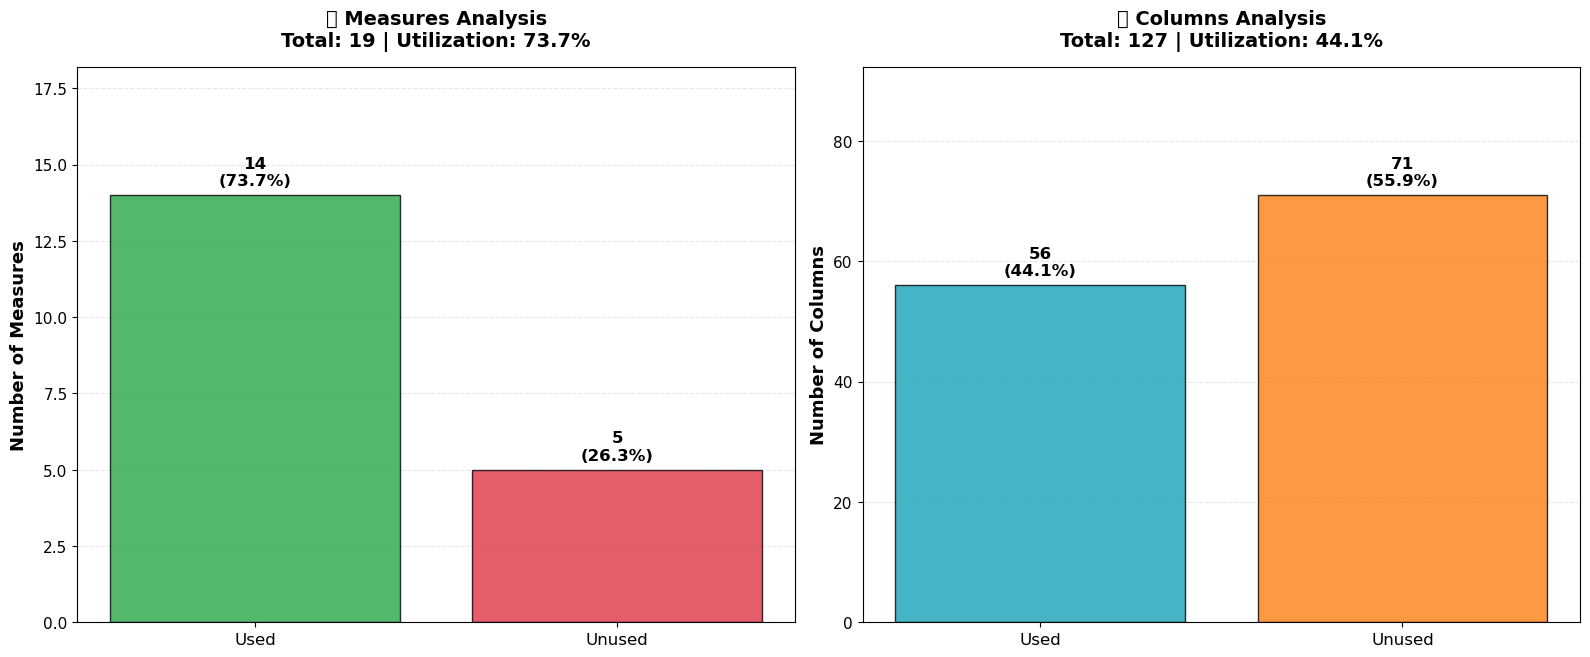


🎯 ANALYSIS COMPLETE - OPTIMIZATION SUMMARY
📊 Measures: 5/19 unused (26.3%)
📊 Columns:  71/127 unused (55.9%)
📊 Tables:   1/17 unused (5.9%)
📊 Relationships: 8 active, 1 inactive
🚀 Analysis completed successfully!


In [27]:
# 🚀 EXECUTE COMPLETE ANALYSIS WITH DUAL VISUALIZATION
# Run this cell to perform comprehensive semantic model analysis
# Features dual charts showing both measures and columns utilization

analysis_results = run_complete_analysis(dataset, workspace, report)